### FP32 without XLA compilation

In [1]:
from time import time

import tensorflow as tf

print('TensorFlow: ', tf.__version__)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

policy = tf.keras.mixed_precision.experimental.Policy('float32')
tf.keras.mixed_precision.experimental.set_policy(policy)

print('\nCompute dtype: ', policy.compute_dtype)
print('Variable dtype: ', policy.variable_dtype)

def _generate_random_image(h, w):
    image = tf.random.uniform(shape=[h, w, 3], maxval=1)
    return image

def _generate_random_label(num_classes):
    return tf.random.uniform(shape=[], maxval=10)

def _get_data(_id):
    image = _generate_random_image(256, 256)
    label = _generate_random_label(10)
    return image, label

batch_size = 128
epochs = 1

num_samples = 5000
train_steps = num_samples // batch_size


autotune = tf.data.experimental.AUTOTUNE

dataset = tf.data.Dataset.range(num_samples)
dataset = dataset.map(_get_data, num_parallel_calls=autotune) \
                 .batch(batch_size, drop_remainder=True) \
                 .repeat() \
                 .prefetch(autotune)

base_model = tf.keras.applications.ResNet50(include_top=False, pooling='avg')
x = tf.keras.layers.Dense(10)(base_model.output)
predictions = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

print('\ninternal layer output dtype: ', model.layers[21].output.dtype)
print('final layer output dtype: ', model.output.dtype, '\n')

optimizer = tf.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

print('\nBatch size: ', batch_size)

print('\nwarmup .fit run')
model.fit(dataset, epochs=epochs, steps_per_epoch=1)
print('\n')


print('\nmain .fit run')
start_time = time()

model.fit(dataset, epochs=epochs, steps_per_epoch=train_steps)

end_time = time()



del optimizer

optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer)

def train(num_steps):
    
    @tf.function
    def train_step(image, labels):
        with tf.GradientTape() as tape:
            outputs = model(image, training=True)
            loss = tf.losses.sparse_categorical_crossentropy(labels, outputs)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss
    
    print('\nwarmup custom loop run\n')
    for image, labels in dataset.take(1):
        _ = train_step(image, labels)

    print('\nmain custom loop run\n')
    start_time = time()
    for step, (image, labels) in enumerate(dataset):
        _ = train_step(image, labels)
        print('[{}]'.format(step+1), end='.')
        if step+1 == num_steps: break
    end_time = time()
    
    return end_time - start_time


time = train(train_steps)

print('\n\n.fit method training time: {:.2f}'.format(end_time - start_time))
print('custom training loop training time: {:.2f}'.format(time))

TensorFlow:  2.2.0-rc3

Compute dtype:  float32
Variable dtype:  float32

internal layer output dtype:  <dtype: 'float32'>
final layer output dtype:  <dtype: 'float32'> 


Batch size:  128

warmup .fit run
1/1 [==============================] - 0s 4ms/step - loss: 2.4609



main .fit run
39/39 [==============================] - 16s 418ms/step - loss: 2.4208

warmup custom loop run


main custom loop run

[1].[2].[3].[4].[5].[6].[7].[8].[9].[10].[11].[12].[13].[14].[15].[16].[17].[18].[19].[20].[21].[22].[23].[24].[25].[26].[27].[28].[29].[30].[31].[32].[33].[34].[35].[36].[37].[38].[39].

.fit method training time: 16.78
custom training loop training time: 16.44


In [5]:
# reset kernel
exit()

### FP32 with XLA compilation

In [1]:
from time import time

import tensorflow as tf

print('TensorFlow: ', tf.__version__)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit"

tf.config.optimizer.set_jit(True)

policy = tf.keras.mixed_precision.experimental.Policy('float32')
tf.keras.mixed_precision.experimental.set_policy(policy)

print('\nCompute dtype: ', policy.compute_dtype)
print('Variable dtype: ', policy.variable_dtype)

def _generate_random_image(h, w):
    image = tf.random.uniform(shape=[h, w, 3], maxval=1)
    return image

def _generate_random_label(num_classes):
    return tf.random.uniform(shape=[], maxval=10)

def _get_data(_id):
    image = _generate_random_image(256, 256)
    label = _generate_random_label(10)
    return image, label

batch_size = 128
epochs = 1

num_samples = 5000
train_steps = num_samples // batch_size


autotune = tf.data.experimental.AUTOTUNE

dataset = tf.data.Dataset.range(num_samples)
dataset = dataset.map(_get_data, num_parallel_calls=autotune) \
                 .batch(batch_size, drop_remainder=True) \
                 .repeat() \
                 .prefetch(autotune)

base_model = tf.keras.applications.ResNet50(include_top=False, pooling='avg')
x = tf.keras.layers.Dense(10)(base_model.output)
predictions = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

print('\ninternal layer output dtype: ', model.layers[21].output.dtype)
print('final layer output dtype: ', model.output.dtype, '\n')

optimizer = tf.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

print('\nBatch size: ', batch_size)

print('\nwarmup .fit run')
model.fit(dataset, epochs=epochs, steps_per_epoch=1)
print('\n')


print('\nmain .fit run')
start_time = time()

model.fit(dataset, epochs=epochs, steps_per_epoch=train_steps)

end_time = time()



del optimizer

optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer)

def train(num_steps):
    
    @tf.function(experimental_compile=True)
    def train_step(image, labels):
        with tf.GradientTape() as tape:
            outputs = model(image, training=True)
            loss = tf.losses.sparse_categorical_crossentropy(labels, outputs)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss
    
    print('\nwarmup custom loop run\n')
    for image, labels in dataset.take(1):
        _ = train_step(image, labels)

    print('\nmain custom loop run\n')
    start_time = time()
    for step, (image, labels) in enumerate(dataset):
        _ = train_step(image, labels)
        print('[{}]'.format(step+1), end='.')
        if step+1 == num_steps: break
    end_time = time()
    
    return end_time - start_time


time = train(train_steps)

print('\n\n.fit method training time: {:.2f}'.format(end_time - start_time))
print('custom training loop training time: {:.2f}'.format(time))

TensorFlow:  2.2.0-rc3

Compute dtype:  float32
Variable dtype:  float32

internal layer output dtype:  <dtype: 'float32'>
final layer output dtype:  <dtype: 'float32'> 


Batch size:  128

warmup .fit run
1/1 [==============================] - 0s 5ms/step - loss: 2.4631



main .fit run
39/39 [==============================] - 14s 365ms/step - loss: 2.3767

warmup custom loop run


main custom loop run

[1].[2].[3].[4].[5].[6].[7].[8].[9].[10].[11].[12].[13].[14].[15].[16].[17].[18].[19].[20].[21].[22].[23].[24].[25].[26].[27].[28].[29].[30].[31].[32].[33].[34].[35].[36].[37].[38].[39].

.fit method training time: 14.70
custom training loop training time: 13.96


In [2]:
#reset kernel
exit()

### FP16 Mixed Precision without XLA compilation

In [1]:
from time import time

import tensorflow as tf

print('TensorFlow: ', tf.__version__)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)

print('\nCompute dtype: ', policy.compute_dtype)
print('Variable dtype: ', policy.variable_dtype)

def _generate_random_image(h, w):
    image = tf.random.uniform(shape=[h, w, 3], maxval=1)
    return image

def _generate_random_label(num_classes):
    return tf.random.uniform(shape=[], maxval=10)

def _get_data(_id):
    image = _generate_random_image(256, 256)
    label = _generate_random_label(10)
    return image, label

batch_size = 256
epochs = 1

num_samples = 5000
train_steps = num_samples // batch_size


autotune = tf.data.experimental.AUTOTUNE

dataset = tf.data.Dataset.range(num_samples)
dataset = dataset.map(_get_data, num_parallel_calls=autotune) \
                 .batch(batch_size, drop_remainder=True) \
                 .repeat() \
                 .prefetch(autotune)

base_model = tf.keras.applications.ResNet50(include_top=False, pooling='avg')
x = tf.keras.layers.Dense(10)(base_model.output)
predictions = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

print('\ninternal layer output dtype: ', model.layers[21].output.dtype)
print('final layer output dtype: ', model.output.dtype, '\n')

optimizer = tf.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

print('\nBatch size: ', batch_size)

print('\nwarmup .fit run')
model.fit(dataset, epochs=epochs, steps_per_epoch=1)
print('\n')


print('\nmain .fit run')
start_time = time()

model.fit(dataset, epochs=epochs, steps_per_epoch=train_steps)

end_time = time()



del optimizer

optimizer = tf.optimizers.Adam()
optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(optimizer, loss_scale='dynamic')
model.compile(optimizer=optimizer)

def train(num_steps):
    
    @tf.function
    def train_step(image, labels):
        with tf.GradientTape() as tape:
            outputs = model(image, training=True)
            loss = tf.losses.sparse_categorical_crossentropy(labels, outputs)
            scaled_loss = optimizer.get_scaled_loss(loss)
        scaled_grads = tape.gradient(scaled_loss, model.trainable_weights)
        grads = optimizer.get_unscaled_gradients(scaled_grads)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss
    
    print('\nwarmup custom loop run\n')
    for image, labels in dataset.take(1):
        _ = train_step(image, labels)

    print('\nmain custom loop run\n')
    start_time = time()
    for step, (image, labels) in enumerate(dataset):
        _ = train_step(image, labels)
        print('[{}]'.format(step+1), end='.')
        if step+1 == num_steps: break
    end_time = time()
    
    return end_time - start_time


time = train(train_steps)

print('\n\n.fit method training time: {:.2f}'.format(end_time - start_time))
print('custom training loop training time: {:.2f}'.format(time))

TensorFlow:  2.2.0-rc3

Compute dtype:  float16
Variable dtype:  float32

internal layer output dtype:  <dtype: 'float16'>
final layer output dtype:  <dtype: 'float32'> 


Batch size:  256

warmup .fit run
1/1 [==============================] - 0s 4ms/step - loss: 2.5260



main .fit run
19/19 [==============================] - 9s 464ms/step - loss: 2.3880

warmup custom loop run


main custom loop run

[1].[2].[3].[4].[5].[6].[7].[8].[9].[10].[11].[12].[13].[14].[15].[16].[17].[18].[19].

.fit method training time: 9.35
custom training loop training time: 9.31


In [2]:
# reset kernel
exit()

### FP316 Mixed Precision with XLA compilation

In [1]:
from time import time

import tensorflow as tf

print('TensorFlow: ', tf.__version__)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit"

tf.config.optimizer.set_jit(True)

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)

print('\nCompute dtype: ', policy.compute_dtype)
print('Variable dtype: ', policy.variable_dtype)

def _generate_random_image(h, w):
    image = tf.random.uniform(shape=[h, w, 3], maxval=1)
    return image

def _generate_random_label(num_classes):
    return tf.random.uniform(shape=[], maxval=10)

def _get_data(_id):
    image = _generate_random_image(256, 256)
    label = _generate_random_label(10)
    return image, label

batch_size = 256
epochs = 1

num_samples = 5000
train_steps = num_samples // batch_size


autotune = tf.data.experimental.AUTOTUNE

dataset = tf.data.Dataset.range(num_samples)
dataset = dataset.map(_get_data, num_parallel_calls=autotune) \
                 .batch(batch_size, drop_remainder=True) \
                 .repeat() \
                 .prefetch(autotune)

base_model = tf.keras.applications.ResNet50(include_top=False, pooling='avg')
x = tf.keras.layers.Dense(10)(base_model.output)
predictions = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

print('\ninternal layer output dtype: ', model.layers[21].output.dtype)
print('final layer output dtype: ', model.output.dtype, '\n')

optimizer = tf.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

print('\nBatch size: ', batch_size)

print('\nwarmup .fit run')
model.fit(dataset, epochs=epochs, steps_per_epoch=1)
print('\n')


print('\nmain .fit run')
start_time = time()

model.fit(dataset, epochs=epochs, steps_per_epoch=train_steps)

end_time = time()



del optimizer

optimizer = tf.optimizers.Adam()
optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(optimizer, loss_scale='dynamic')
model.compile(optimizer=optimizer)

def train(num_steps):
    
    @tf.function(experimental_compile=True)
    def train_step(image, labels):
        with tf.GradientTape() as tape:
            outputs = model(image, training=True)
            loss = tf.losses.sparse_categorical_crossentropy(labels, outputs)
            scaled_loss = optimizer.get_scaled_loss(loss)
        scaled_grads = tape.gradient(scaled_loss, model.trainable_weights)
        grads = optimizer.get_unscaled_gradients(scaled_grads)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss
    
    print('\nwarmup custom loop run\n')
    for image, labels in dataset.take(1):
        _ = train_step(image, labels)

    print('\nmain custom loop run\n')
    start_time = time()
    for step, (image, labels) in enumerate(dataset):
        _ = train_step(image, labels)
        print('[{}]'.format(step+1), end='.')
        if step+1 == num_steps: break
    end_time = time()
    
    return end_time - start_time


time = train(train_steps)

print('\n\n.fit method training time: {:.2f}'.format(end_time - start_time))
print('custom training loop training time: {:.2f}'.format(time))

TensorFlow:  2.2.0-rc3

Compute dtype:  float16
Variable dtype:  float32

internal layer output dtype:  <dtype: 'float16'>
final layer output dtype:  <dtype: 'float32'> 


Batch size:  256

warmup .fit run
1/1 [==============================] - 0s 6ms/step - loss: 2.4583



main .fit run
19/19 [==============================] - 6s 309ms/step - loss: 2.3790

warmup custom loop run


main custom loop run

[1].[2].[3].[4].[5].[6].[7].[8].[9].[10].[11].[12].[13].[14].[15].[16].[17].[18].[19].

.fit method training time: 6.24
custom training loop training time: 4.92


In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

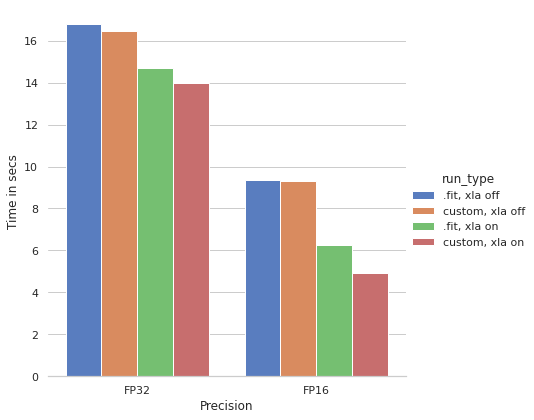

In [2]:
run_times = {
    'Precision': ['FP32', 'FP32', 'FP32', 'FP32', 'FP16', 'FP16', 'FP16', 'FP16'],
    'run_type': ['.fit, xla off',
                 'custom, xla off',
                 '.fit, xla on',
                 'custom, xla on',
                 '.fit, xla off',
                 'custom, xla off',
                 '.fit, xla on',
                 'custom, xla on'],
    'times': [16.78, 16.44, 14.7, 13.96, 9.35, 9.31, 6.24, 4.92],
}

g = sns.catplot(x='Precision', y='times', hue='run_type', data=pd.DataFrame.from_dict(run_times),
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels('Time in secs')